In [4]:
from utilities.evaluator import Evaluator
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from utilities.misc import dict_to_json
%load_ext autoreload
%autoreload 2

In [5]:
from utilities.variational import VQE
from utilities.evaluator import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder

bond=1.5
problem_config ={"problem" : "H4", 
                               "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., bond)), ('H', (0., 0., 2*bond)), ('H', (0., 0., 3*bond))], 
                               "multiplicity":1, "charge":0, "basis":"sto-3g"}
q=8
vqe_handler = VQE(n_qubits=q, lr=0.01, epochs=2000,
                    noise_config={}, problem_config=problem_config,
                    patience=200, random_perturbations=True, 
                  return_lower_bound=1, optimizer="adam")

iid = IdInserter(n_qubits=len(vqe_handler.qubits))
Simp = Simplifier(n_qubits=len(vqe_handler.qubits))
killer = UnitaryMurder(vqe_handler, noise_config={})
fci = vqe_handler.lower_bound_energy


In [6]:
from utilities.chemical import ChemicalObservable, OpenFermion_to_Cirq
oo = ChemicalObservable()
observable, lower_bound_energy =oo.give_observable(vqe_handler.qubits, problem_config["geometry"],
                                                   problem_config["multiplicity"], problem_config["charge"],
                                                   problem_config["basis"],return_lower_bound=True)


In [7]:
import cirq
def compute_ground_energy_1(obse,qubits):
    """
    TO do. Implement this for, say, 6 qubits (therer's a problem in give_kr_prod...)
    """
    ind_to_2 = {"0":np.eye(2), "1":cirq.unitary(cirq.X), "2":cirq.unitary(cirq.Y), "3":cirq.unitary(cirq.Z)}
    ham = np.zeros((2**len(qubits),2**len(qubits))).astype(np.complex128)
    for kham in obse:
        item= kham.dense(qubits)
        string = item.pauli_mask
        matrices = [ind_to_2[str(int(ok))] for ok in string]
        ham += give_kr_prod(matrices)*item.coefficient
    return np.sort(np.real(np.linalg.eigvals(ham)))


In [9]:
compute_ground_energy_1(vqe_handler.qubits,observable)

ValueError: Maximum allowed dimension exceeded

In [11]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

geometry=[('H', (0., 0., 0.)), ('H', (0., 0., bond)), ('H', (0., 0., 2*bond)), ('H', (0., 0., 3*bond))]
basis="sto-3g"
multiplicity=1

molecule = MolecularData(geometry, basis=basis, multiplicity=multiplicity)
molecule = run_pyscf(molecule,run_scf=0,run_mp2=0,run_cisd=0,run_ccsd=0,run_fci=1)

In [12]:
fci=molecule.fci_energy
fci

-1.9961503255188093

In [87]:
path="/data/uab-giq/scratch/matias/data-vans/"
#path = "../data-vans/"
bond=1.5
nconts=[]
bads=0
nparams=[]
lowestenergy=[]
for nrun in tqdm(range(1,99)):
    try:
        problem_config={"problem" : "H4", "geometry": str([('H', (0., 0., 0.)), ('H', (0., 0., bond)), ('H', (0., 0., 2*bond)), ('H', (0., 0., 3*bond))]).replace("'",""), "multiplicity":1, "charge":0, "basis":"sto-3g"}
        arguss= {"n_qubits":8,"problem_config":problem_config,"specific_name":"_singlebond_nrun{}".format(float(nrun)), "noise_config":{}}
        evaluator = Evaluator(args=arguss,loading=True,path="{}".format(path))
        nconts.append(evaluator.number_cnots_best())
        nparams.append(len(evaluator.evolution[evaluator.get_best_iteration()[0]][2]))
        lowestenergy.append(evaluator.evolution[evaluator.get_best_iteration()[0]][4])
    except Exception:
        bads+=1

100%|██████████| 98/98 [01:43<00:00,  1.05s/it]


In [131]:
nconts = np.array(nconts)
lowestenergy=np.array(lowestenergy)
nparams=np.array(nparams)
np.save("resuh4run/nconts",nconts)
np.save("resuh4run/nparams",nparams)
np.save("resuh4run/lowestenergy",lowestenergy)


In [8]:
nconts=np.load("resuh4run/nconts.npy")
nparams=np.load("resuh4run/nparams.npy")
lowestenergy=np.load("resuh4run/lowestenergy.npy")

In [9]:
np.sort(lowestenergy)

array([-1.9949881, -1.994915 , -1.9947252, -1.994151 , -1.9940431,
       -1.9904932, -1.9817305, -1.9790623, -1.9790249, -1.9779917,
       -1.9752166, -1.9750679, -1.9678845, -1.9676579, -1.9657737,
       -1.965331 , -1.9653306, -1.965158 , -1.9650952, -1.9645276,
       -1.96279  , -1.962275 , -1.9559717, -1.9534771, -1.9525874,
       -1.9451331, -1.94497  , -1.943763 , -1.9320862, -1.9306335,
       -1.9253795, -1.9200417, -1.9181707, -1.9162221, -1.9160621,
       -1.9150822, -1.912723 , -1.9122819, -1.9118679, -1.9098502,
       -1.9098444, -1.9098265, -1.9079826, -1.9078243, -1.8977007,
       -1.8956885, -1.8875704, -1.8866643, -1.8844371, -1.8819506,
       -1.880651 , -1.8699474, -1.8671525, -1.8658078, -1.8636953,
       -1.8521333, -1.8509231, -1.8418158, -1.8418138, -1.8329873,
       -1.8302209, -1.822129 , -1.8132709, -1.8132707, -1.8132706,
       -1.8132463, -1.8095202, -1.8080587, -1.7940155, -1.7924225,
       -1.7924224, -1.7924223, -1.786678 , -1.7744936, -1.7404

In [20]:
nconts=np.sort(np.load("resuh4run/nconts.npy"))
nparams=np.sort(np.load("resuh4run/nparams.npy"))
lowestenergy=np.sort(np.load("resuh4run/lowestenergy.npy"))

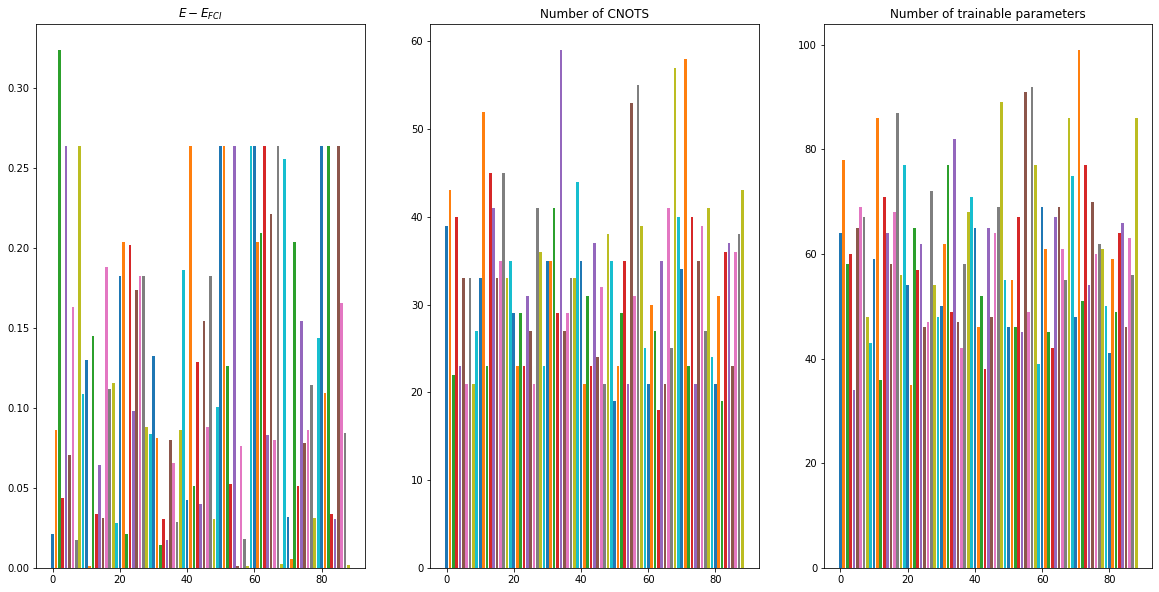

In [14]:
plt.figure(figsize=(20,10))
plt.title("H-H-H-H\nBond-length 1.5 A")
ax = [plt.subplot2grid((1,3), (0,k)) for k in range(3)]

for k, arr in zip(range(3), [lowestenergy,nconts,nparams]):
    for v,b in enumerate(arr):
        if k==0:
            ax[k].bar(v,b-fci)
        else:
            ax[k].bar(v,b)
        ax[k].set_title([r'$E-E_{FCI}$', "Number of CNOTS","Number of trainable parameters"][k])
#plt.savefig("h4_better_results.png")

In [18]:
np.sort(lowestenergy-(fci+0.0016))

array([-4.37736511e-04, -3.64661217e-04, -1.74880028e-04,  3.99351120e-04,
        5.07235527e-04,  4.05716896e-03,  1.28198862e-02,  1.54880285e-02,
        1.55254602e-02,  1.65586472e-02,  1.93337202e-02,  1.94824934e-02,
        2.66658068e-02,  2.68924236e-02,  2.87766457e-02,  2.92193890e-02,
        2.92197466e-02,  2.93923616e-02,  2.94551849e-02,  3.00227404e-02,
        3.17603350e-02,  3.22753191e-02,  3.85786295e-02,  4.10732031e-02,
        4.19629812e-02,  4.94172573e-02,  4.95803356e-02,  5.07873297e-02,
        6.24641180e-02,  6.39168024e-02,  6.91708326e-02,  7.45086670e-02,
        7.63796568e-02,  7.83282518e-02,  7.84882307e-02,  7.94681311e-02,
        8.18274021e-02,  8.22684765e-02,  8.26824903e-02,  8.47001076e-02,
        8.47059488e-02,  8.47238302e-02,  8.65677595e-02,  8.67260695e-02,
        9.68496799e-02,  9.88618135e-02,  1.06979966e-01,  1.07886076e-01,
        1.10113263e-01,  1.12599730e-01,  1.13899350e-01,  1.24602914e-01,
        1.27397895e-01,  

In [106]:
positions = np.where(lowestenergy-chemac < 0)

In [13]:
lowestenergy[positions]-fci

NameError: name 'positions' is not defined

-1.9929503255188075

In [4]:
circ, energy, indexed_circuit,resolver, lowest_energy = evaluator.evolution[len(evaluator.evolution.keys())-1]
itsen=[]
itslen=[]
ncnots=[]
nparams=[]
for k in tqdm(range(len(evaluator.evolution.keys()))):
    things = evaluator.evolution[k]
    itsen.append(things[1])
    itslen.append(things[-1])
    ncnots.append(vqe_handler.count_cnots(things[2]))
    nparams.append(len(things[2]) - ncnots[-1])
    if evaluator.evolution[k][1] == lowest_energy:
        pcirc, penergy, pindexed_circuit,presolver, plowest_energy = things

100%|██████████| 63/63 [00:00<00:00, 11658.56it/s]


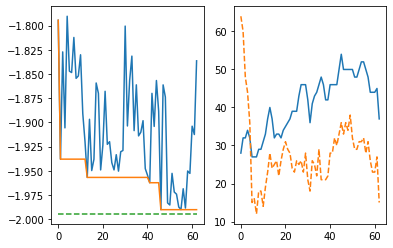

In [5]:
ax1, ax2 = [plt.subplot2grid((1,2),(0,k)) for k in range(2)]
ax1.plot(itsen, label="energy of current circuit")
ax1.plot(itslen, label="lowest found")
ax1.plot(np.ones(len(itslen))*vqe_handler.lower_bound_energy,'--', label="FCI")

ax2.plot(ncnots)
ax2.plot(nparams,'--')

Let's try now to add gates to the circuit, so it converges :) 

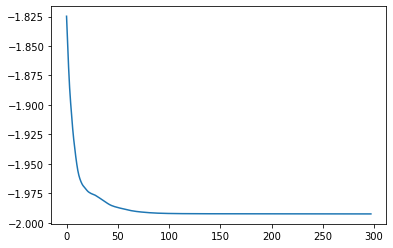

In [62]:
energy, symbol_to_value, training_evolution = vqe_handler.vqe(pindexed_circuit, symbols_to_values=presolver) #compute energy
plt.plot(training_evolution.history["energy"])

In [94]:
def gate_counter_on_qubits(self, indexed_circuit):
    ngates = {k:[0,0] for k in range(len(self.qubits))}
    for ind in indexed_circuit:
        if ind < self.number_of_cnots:
            control, target = self.indexed_cnots[str(ind)]
            ngates[control][1]+=1
            ngates[target][1]+=1   
        else:
            qind = (ind-self.number_of_cnots)%self.n_qubits
            ngates[qind][0]+=1
    return ngates

In [93]:
gate_counter(vqe_handler, indexed_circuit)

{0: [3, 7],
 1: [2, 4],
 2: [1, 6],
 3: [1, 10],
 4: [1, 14],
 5: [2, 12],
 6: [1, 12],
 7: [4, 9]}

In [107]:
def choose_qubit_from_N1q(self, beta=10):
    """
    Note that beta could be annealed as energy decreases.. (at beta = 0 we get uniform sampling)
    function that selects qubit according to how many gates are acting on each one in the circuit
    """
    gc=np.array(list(ngates.values()))[:,0] #### gives the gate population for each qubit
    probs=np.exp(beta*(1-gc/np.sum(gc)))/np.sum(np.exp(beta*(1-gc/np.sum(gc))))
    return np.random.choice(range(vqe_handler.n_qubits),1,p=probs)[0]

In [112]:
gc=np.array(list(ngates.values()))[:,1] #### gives the gate population for each qubit
probs=np.exp(beta*(1-gc/np.sum(gc)))/np.sum(np.exp(beta*(1-gc/np.sum(gc))))

In [124]:
np.random.choice(range(vqe_handler.n_qubits),2,p=probs, replace=False)

array([3, 0])

In [55]:
circuit = vqe_handler.give_circuit(indexed_circuit)[0]


TypeError: operation_at() missing 1 required positional argument: 'moment_index'

In [63]:
import cirq

False

In [ ]:
iid.inserter(indexed_circuit,resolver,-1)